# <center>Contrastive Learning</center>

### <center>Using SimCLR to illustrate the principles of self-supervised contrastive learning (CL)</center>

<center>Nick Glaser</center>


## CL - Introduction

- What's the need for CL?
  - Leverage large amounts of unlabeled data
  - Build _good_ transfer learning models
    - [Cross-entropy-trained models generally have suboptimal transfer performance](https://arxiv.org/abs/2103.13517)
    - [Transferability depends on many factors and is fragile in XEnt CV models](https://arxiv.org/abs/1411.1792)

[//]: # "Transferring between tasks is hard. Task similarity matters, data similarity matters. Classic classification & xent loss results in very semantically high-level features, e.g. petal-detectors - good for IRIS transfer, bad for medical images and planes. Can be combatted by using intermediate network layers instead of last but still run into issues, lower features might be too general, co-adapted neurons from original task cause instabilities, etc."


![image](./media/transfer_learning.jpeg)


![image](./media/imagenet_v_cl.jpeg)


- How can we frame a learning problem when we don't have labels for our data?
  - Intuition: one-versus-rest/ instance-level classification [Wu et al. 2018](https://arxiv.org/abs/1805.01978v1)
  - Learn embeddings that are similar for variations of the same sample while different for other examples


- Formalize a problem statement
  - Anchor $x$: Random sample drawn from data distribution
  - Positive sample $x^+$: Semantically similar sample to anchor
  - Negative sample $x^-$: Semantically disimilar sample to anchor
  - Encoder function $f: x \mapsto \textbf{h}$
  - **Goal**: learn $f$ such that $x$ and $x^+$ are closer in embedding space and $x$ and $x^-$ are far away, formally:

**Contrastive learning seeks to satisfy**:
$sim(\textbf{h}, \textbf{h}^+) > sim(\textbf{h}, \textbf{h}^-)$

- Negative examples are easy to obtain for instance-level discrimination, but how do we get good positive examples?
  - Pretext tasks!


![image](./media/augmentations.jpeg)


In [1]:
# some preprocessing code adapted from https://github.com/PyTorchLightning/lightning-bolts/
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

from demo_src.data_utils import util as data_util
from torchvision import transforms

# normalization stats for rgb channels
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)
cifar100_dim = 32

# augmentations, can modify values
normalize = transforms.Normalize(mean=cifar100_mean, std=cifar100_std)
horizontal_flip = transforms.RandomHorizontalFlip(p=0.5)
color_jitter = transforms.RandomApply(
    [transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8)
grayscale = transforms.RandomGrayscale(p=0.2)
gauss_blur = transforms.RandomApply([data_util.GaussianBlur2()], p=0.5)
resized_crop = transforms.RandomResizedCrop(size=cifar100_dim)

# allowed transforms
transform_dict = {
    'horizontal_flip': horizontal_flip,
    'color_jitter': color_jitter,
    'grayscale': grayscale,
    'gauss_blur': gauss_blur,
    'resized_crop': resized_crop
}

transform_widget = widgets.SelectMultiple(
    options=transform_dict.keys(),
    value=['resized_crop', 'color_jitter', 'grayscale', 'gauss_blur'],
    description='Data Transforms',
    disabled=False
)

transform_widget


SelectMultiple(description='Data Transforms', index=(4, 1, 2, 3), options=('horizontal_flip', 'color_jitter', …

In [2]:
# fetch widget values and close widget
selected_transforms = transform_widget.value
print(selected_transforms)
transform_widget.close()

# training transforms for local views
transf_list = [transform_dict[transf] for transf in selected_transforms]
train_transform = transforms.Compose(
    transf_list + [transforms.ToTensor(), normalize])

# transform for global view
eval_transform = transforms.Compose([transforms.Resize((int(cifar100_dim*0.1 + cifar100_dim))),
                                    transforms.CenterCrop(cifar100_dim),
                                    transforms.ToTensor(), normalize])


def contrastive_transform(sample):
    x_i = train_transform(sample)
    x_j = train_transform(sample)

    return x_i, x_j, eval_transform(sample), transforms.ToTensor()(sample)


('resized_crop', 'color_jitter', 'grayscale', 'gauss_blur')


In [3]:
cifar_100_train = data_util.CIFAR100CL(root='../data/raw/',
                                       train=True,
                                       transform=contrastive_transform,
                                       download=True
                                       )

cifar_100_test = data_util.CIFAR100CL(root='../data/raw/',
                                      train=False,
                                      transform=contrastive_transform,
                                      download=True
                                      )

train_iter = iter(cifar_100_train)


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


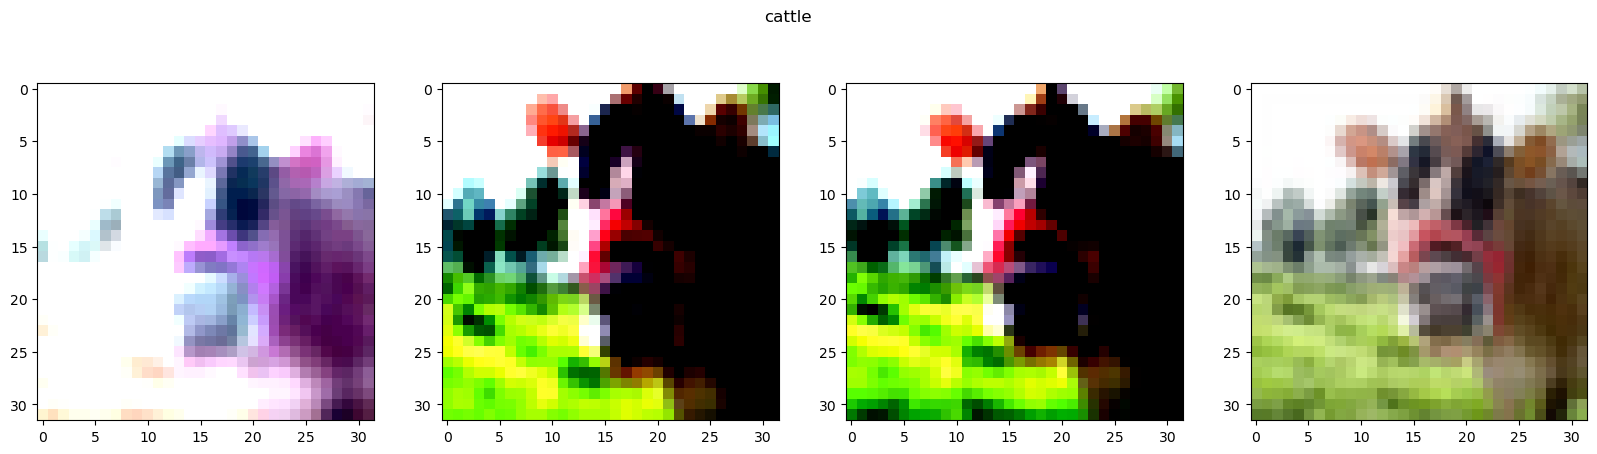

In [4]:
im, idx, lbl = next(train_iter)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle(cifar_100_train.classes[lbl])
for i in range(4):
    tmp = im[i].transpose(0, 2).transpose(0, 1)
    axs[i].imshow(tmp)
plt.show()


## SimCLR


<p float="left">
  <img src="./media/cl_overview.gif" width="315" />
  <img src="./media/simclr_overview.png" width="451" /> 
</p>


### How can we go about "maximizing agreement"?


![image](./media/agreement_office.jpeg)


- Measure of similarity $\text{sim}(.,.)$: cosine similarity
  **$\mathrm{sim}(\bm u,\bm v) = \bm u^\top \bm v / \lVert\bm u\rVert \lVert\bm v\rVert$**

[//]: # "l2 norm applied for cosine similarity - as opposed to in dot product - is form of regularization and thus might help restrict network. SimCLR results show that using dot product improves CL task performance but degrades transfer performance -> overfitting"

- Loss to be minimized:
  #### $\mathcal{L}_{(i,j)} = - \log\frac{\exp(\text{sim}(\mathbf{z}_i, \mathbf{z}_j) / \tau)}{\sum_{k=1}^{2N} \mathbb{1}_{[k \neq i]} \exp(\text{sim}(\mathbf{z}_i, \mathbf{z}_k) / \tau)}$
- Toy example for a batch of 2 examples (part of [this excellent blog post](https://medium.datadriveninvestor.com/simclr-part-2-the-encoder-projection-head-and-loss-function-809a64f30d4a)):
  - Transform and encode both examples to obtain $z_1, z_2, z_3, z_4$
  - Let's focus on just $z_1$ and calculate all pairwise similarities:
    - $a = \mathrm{sim}(\bm z_1,\bm z_2)$
    - $b = \mathrm{sim}(\bm z_1,\bm z_3)$
    - $c = \mathrm{sim}(\bm z_1,\bm z_4)$
  - In order to maximize a while minimizing b and c, and easy loss could be:
    ### $\frac{b+c}{a}$ → $\frac{e^{b}+e^{c}}{e^{a}}$ → $1 + \frac{e^{b}+e^{c}}{e^{a}}$ → $\frac{e^{a}+e^{b}+e^{c}}{e^{a}}$
  - And now to arrive at the cross-entropy part:
    ### $\log(\frac{e^{a}+e^{b}+e^{c}}{e^{a}})$ → $\log((\frac{e^{a}}{e^{a}+e^{b}+e^{c}})^{-1})$ → $-\log(\frac{e^{a}}{e^{a}+e^{b}+e^{c}})$
  - Add temperature scaling and you have the NT-XEnt loss for one of the embeddings of a single example:
    ### $-\log(\frac{e^\frac{{a}}{t}}{e^\frac{{a}}{t}+e^\frac{{b}}{t}+e^\frac{{c}}{t}})$
- Uniquely desirable property of this loss:
  - Implicitly weighs "hard negatives" - negatives with high similarity to the anchor - highly


In [5]:
import pytorch_lightning as pl
import torch.utils.data as data
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

from demo_src.model_utils import frameworks

def simclr_trainer(train_ds, val_ds, batch_size=128, max_epochs=500, **kwargs):
    tb_logger = pl_loggers.TensorBoardLogger(save_dir='../results/simclr_demo/lightning_logs')
    trainer = Trainer(
        default_root_dir='../results/simclr_demo/model_checkpoints',
        gpus=0,
        max_epochs=500,
        callbacks=[
            ModelCheckpoint(save_weights_only=False, mode="min", monitor="train_loss"),
            LearningRateMonitor("epoch"),
        ],
        logger=tb_logger,
        log_every_n_steps=2
    )
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=0,
        drop_last=True)

    valid_loader = data.DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=0,
        drop_last=True)

    pl.seed_everything(13)
    
    model = frameworks.SimCLR(
        gpus=1,
        num_samples=len(cifar_100_train),
        batch_size=batch_size,
        arch='resnet18',
        max_epochs=max_epochs,
        hidden_mlp=512  # 2048 for resnet50
    )
    trainer.fit(model, train_loader, valid_loader)
    
    # load& return best model after training is complete
    model = frameworks.SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    return model

In [6]:
simclr_model = simclr_trainer(cifar_100_train, cifar_100_test, batch_size=128)

/Users/yannikglaser/miniforge3/envs/ssl_demo/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 13

  | Name    | Type             | Params
---------------------------------------------
0 | encoder | ResNet           | 11.2 M
1 | head    | NonlinProjection | 1.3 M 
---------------------------------------------
12.5 M    Trainable params
0         Non-trainable params
12.5 M    Total params
49.974    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/yannikglaser/miniforge3/envs/ssl_demo/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/yannikglaser/miniforge3/envs/ssl_demo/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/yannikglaser/miniforge3/envs/ssl_demo/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/Users/yannikglaser/miniforge3/envs/ssl_demo/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


IsADirectoryError: [Errno 21] Is a directory: '/Users/yannikglaser/Desktop/ssl_demo/notebooks'

## Let's look at some of the observations from the paper:
### Augmentations matter

![image](./media/augmentation_matrix.png)

![image](./media/cl_views.png)

[//]: # "From the paper https://arxiv.org/abs/2005.10243"

### Contrastive learning models are superb semi-supervised and transfer learners

![image](./media/simclr_transfer.png)

![image](./media/semisup_table7.png)

![image](./media/semisup_simclrv2.png)

[//]: # "From the paper https://arxiv.org/abs/2006.10029"

### However, CL is expensive

![image](./media/training_cost.png)